=== FAST PARKINSON'S VOICE ANALYSIS (NPZ VERSION) ===
Dataset: UAMS_DATASET
Mode: ALL_VALIDS
Feature Mode: ALL
Starting comprehensive correlation analysis...

Results will be saved to: correlation_results_UAMS_DATASET_ALL_VALIDS_ALL
Looking for NPZ file: UAMS/data\features_ALL_VALIDS_ALL.npz
Loading and preparing data from NPZ file...
NPZ file contents: ['spectrogram', 'mel_spectrogram', 'fsc', 'mfcc', 'labels', 'sex', 'age']
Loading features: ['mel_spectrogram', 'mfcc', 'spectrogram', 'fsc']
  mel_spectrogram: shape (328, 30, 94)
    Reshaped to: (328, 2820)
  mfcc: shape (328, 30, 94)
    Reshaped to: (328, 2820)
  spectrogram: shape (328, 1025, 94)
    Reshaped to: (328, 96350)
  fsc: shape (328, 1, 94)
    Reshaped to: (328, 94)
Combined feature matrix shape: (328, 102084)
Labels shape: (328,)
Total feature names: 102084
Unique labels: [0 1]
Features: 102084
Samples: 328
Positive cases: 164 (50.0%)

Performing fast correlation analysis...

Feature categorization:
  mel_spectrogram:

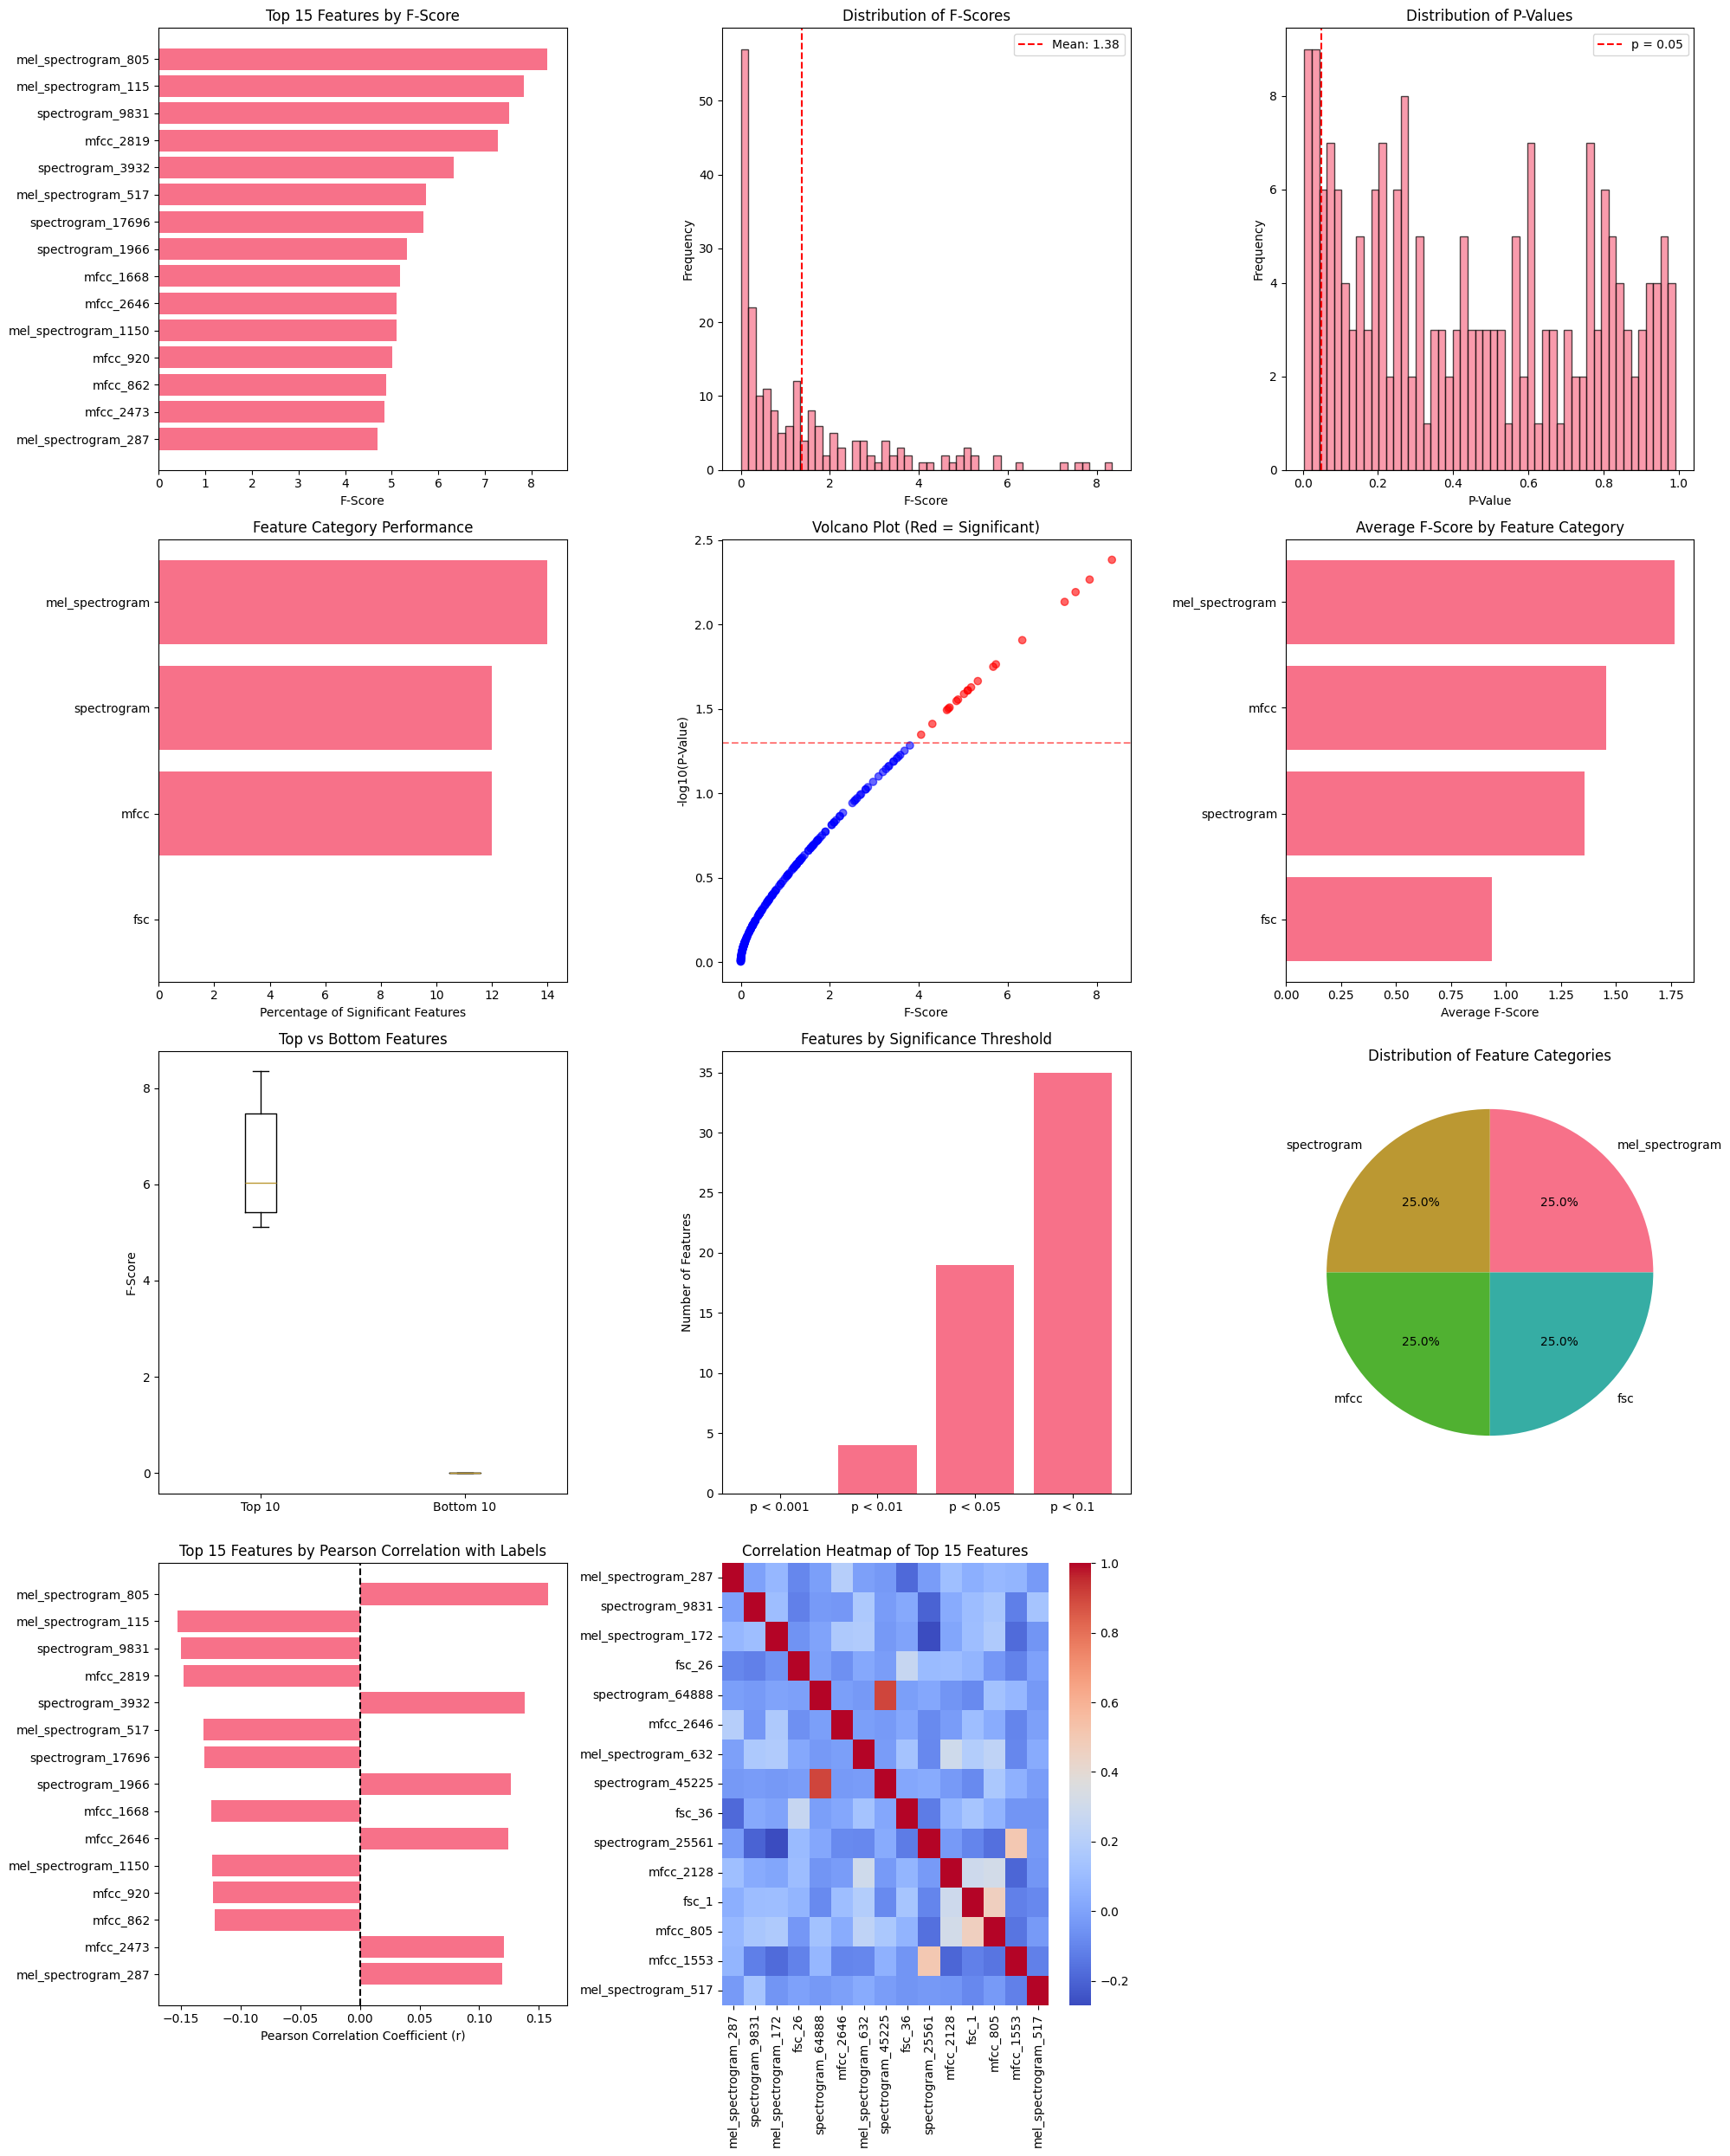

Plots saved: correlation_results_UAMS_DATASET_ALL_VALIDS_ALL\correlation_analysis_plots_UAMS_DATASET_ALL_VALIDS_ALL.png

=== DEEP ANALYSIS ===

=== COMPREHENSIVE ANALYSIS REPORT: UAMS_DATASET ===
Mode: ALL_VALIDS | Feature Mode: ALL

FEATURE CATEGORY QUALITY SUMMARY:

MEL_SPECTROGRAM Features:
  - Total: 50
  - Significant: 7 (14.0%)
  - Average F-score: 1.77
  - Max F-score: 8.34
  - Best features: mel_spectrogram_805, mel_spectrogram_115

SPECTROGRAM Features:
  - Total: 50
  - Significant: 6 (12.0%)
  - Average F-score: 1.36
  - Max F-score: 7.53
  - Best features: spectrogram_9831, spectrogram_3932

MFCC Features:
  - Total: 50
  - Significant: 6 (12.0%)
  - Average F-score: 1.46
  - Max F-score: 7.28
  - Best features: mfcc_2819, mfcc_1668

FSC Features:
  - Total: 50
  - Significant: 0 (0.0%)
  - Average F-score: 0.94
  - Max F-score: 3.33
  - Best features: fsc_43, fsc_45
=== DIAGNOSTIC POTENTIAL ANALYSIS ===
Features with HIGH diagnostic potential: 0

=== RELIABILITY ANALYSIS =

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway, pearsonr
from sklearn.feature_selection import f_classif
import os
import warnings
from datetime import datetime
import json
import re

warnings.filterwarnings('ignore')

# Dataset and mode configurations
ITALIAN_DATASET = "ITALIAN_DATASET"
UAMS_DATASET = "UAMS_DATASET"
NEUROVOZ_DATASET = "NEUROVOZ_DATASET"
MPOWER_DATASET = "MPOWER_DATASET"
SYNTHETIC_DATASET = "SYNTHETIC_DATASET"

MODE_A = "A"
MODE_ALL_VALIDS = "ALL_VALIDS"

FEATURE_MODE_BASIC = "BASIC"        # mel_spectrogram, mfcc, spectrogram
FEATURE_MODE_ALL = "ALL"            # basic + fsc
FEATURE_MODE_ACOUSTIC = "ACOUSTIC"  # acoustic_features only
FEATURE_MODE_COMBINED = "COMBINED"  # all spectral + acoustic features

# --- SELECT YOUR CONFIGURATION HERE ---
DATASET = UAMS_DATASET
MODE = MODE_ALL_VALIDS
FEATURE_MODE = FEATURE_MODE_ALL

# Configuration
SAMPLE_SIZE = 1000  # Adjust based on your needs
MAX_FEATURES_PER_TYPE = 50  # Maximum features to process per type

def get_dataset_path(dataset_name, mode, feature_mode):
    """Generate the path to the NPZ file based on configuration"""
    if dataset_name == UAMS_DATASET:
        base_path = "UAMS/data"
        filename = f"features_{mode}_{feature_mode}.npz"
    else:
        base_path = "data"  # Default path for other datasets
        filename = f"{dataset_name}_{mode}_{feature_mode}.npz"
    return os.path.join(base_path, filename)

def get_results_path(dataset_name, mode, feature_mode):
    """Generate results directory path based on configuration"""
    return f"correlation_results_{dataset_name}_{mode}_{feature_mode}"

def create_output_directory(results_path):
    """Create output directory if it doesn't exist"""
    if not os.path.exists(results_path):
        os.makedirs(results_path)
    print(f"Results will be saved to: {results_path}")
    return results_path

def load_npz_data(file_path, feature_mode):
    """Load and prepare data from NPZ file with flexible structure"""
    print("Loading and preparing data from NPZ file...")

    if not os.path.exists(file_path):
        print(f"Error: NPZ file not found at {file_path}")
        print("Available files in data directory:")
        data_dir = os.path.dirname(file_path)
        if os.path.exists(data_dir):
            for f in os.listdir(data_dir):
                if f.endswith('.npz'):
                    print(f"  - {f}")
        else:
            print(f"  Data directory '{data_dir}' does not exist")
        return None, None, None

    # Load NPZ file
    data = np.load(file_path, allow_pickle=True)

    print(f"NPZ file contents: {list(data.keys())}")

    # Extract labels
    if 'labels' in data.keys():
        y = data['labels']
    elif 'y' in data.keys():
        y = data['y']
    else:
        print("No labels found in NPZ file")
        return None, None, None

    # Determine which features to load based on feature mode
    feature_keys = []
    if feature_mode == FEATURE_MODE_BASIC:
        feature_keys = ['mel_spectrogram', 'mfcc', 'spectrogram']
    elif feature_mode == FEATURE_MODE_ALL:
        feature_keys = ['mel_spectrogram', 'mfcc', 'spectrogram', 'fsc']
    elif feature_mode == FEATURE_MODE_ACOUSTIC:
        feature_keys = ['acoustic_features'] if 'acoustic_features' in data.keys() else []
    elif feature_mode == FEATURE_MODE_COMBINED:
        # All available feature types
        possible_keys = ['mel_spectrogram', 'mfcc', 'spectrogram', 'fsc', 'acoustic_features', 'chroma', 'spectral', 'tempo']
        feature_keys = [key for key in possible_keys if key in data.keys()]

    # Filter for available keys
    available_feature_keys = [key for key in feature_keys if key in data.keys()]

    if not available_feature_keys:
        print(f"No matching feature keys found for mode {feature_mode}")
        print(f"Available keys: {list(data.keys())}")
        return None, None, None

    print(f"Loading features: {available_feature_keys}")

    # Load and concatenate features
    feature_arrays = []
    feature_names = []

    for key in available_feature_keys:
        feature_data = data[key]
        print(f"  {key}: shape {feature_data.shape}")

        # Handle 2D and 3D arrays
        if len(feature_data.shape) == 3:
            # Flatten last two dimensions (e.g., time x frequency -> single vector)
            n_samples = feature_data.shape[0]
            feature_data = feature_data.reshape(n_samples, -1)
            print(f"    Reshaped to: {feature_data.shape}")

        feature_arrays.append(feature_data)

        # Generate feature names
        n_features = feature_data.shape[1]
        names = [f"{key}_{i}" for i in range(n_features)]
        feature_names.extend(names)

    # Concatenate all features
    X = np.concatenate(feature_arrays, axis=1)

    print(f"Combined feature matrix shape: {X.shape}")
    print(f"Labels shape: {y.shape}")
    print(f"Total feature names: {len(feature_names)}")

    # Handle missing values
    if np.any(np.isnan(X)):
        print("Found NaN values, removing affected samples...")
        valid_indices = ~np.any(np.isnan(X), axis=1)
        X = X[valid_indices]
        y = y[valid_indices]
        print(f"After removing NaN values: {X.shape}")

    # Handle infinite values
    if np.any(np.isinf(X)):
        print("Found infinite values, clipping...")
        X = np.clip(X, -1e10, 1e10)

    # Prepare target variable
    unique_labels = np.unique(y)
    print(f"Unique labels: {unique_labels}")

    # Convert labels to binary (0/1) if needed
    if not all(val in [0, 1] for val in unique_labels):
        if len(unique_labels) == 2:
            y = (y == unique_labels[1]).astype(int)
            print(f"Converted labels to binary: {unique_labels} -> [0, 1]")
        else:
            print(f"Warning: More than 2 unique labels found: {unique_labels}")
            print("Using first label as negative (0), rest as positive (1)")
            y = (y != unique_labels[0]).astype(int)

    print(f"Features: {len(feature_names)}")
    print(f"Samples: {len(X)}")
    print(f"Positive cases: {y.sum()} ({y.sum()/len(y)*100:.1f}%)")

    return X, y, feature_names

def categorize_feature_types(feature_columns):
    """Categorize features based on their names"""
    categories = {
        'mel_spectrogram': [],
        'mfcc': [],
        'spectrogram': [],
        'acoustic': [],
        'chroma': [],
        'spectral': [],
        'tempo': [],
        'formant': [],
        'pitch': [],
        'energy': [],
        'fsc': [],
        'other': []
    }

    for feature in feature_columns:
        feature_lower = feature.lower()
        categorized = False

        # Check each category
        for category in categories.keys():
            if category == 'other':
                continue
            if category in feature_lower or feature_lower.startswith(category):
                categories[category].append(feature)
                categorized = True
                break

        if not categorized:
            # Try to extract prefix
            parts = feature.split('_')
            if len(parts) > 1:
                prefix = parts[0].lower()
                if prefix in categories:
                    categories[prefix].append(feature)
                else:
                    categories['other'].append(feature)
            else:
                categories['other'].append(feature)

    # Remove empty categories
    categories = {k: v for k, v in categories.items() if v}

    print("\nFeature categorization:")
    for category, features in categories.items():
        print(f"  {category}: {len(features)} features")

    return categories

def smart_feature_sampling(feature_columns, max_features_per_type=50):
    """Intelligently sample features to reduce computational load"""

    # Categorize features
    feature_categories = categorize_feature_types(feature_columns)

    # Sample features from each category
    selected_features = []

    for category, features in feature_categories.items():
        if len(features) <= max_features_per_type:
            selected_features.extend(features)
        else:
            # Sample evenly distributed indices
            indices = np.linspace(0, len(features)-1, max_features_per_type, dtype=int)
            sampled = [features[i] for i in indices]
            selected_features.extend(sampled)

        print(f"{category}: {len(features)} features -> {min(len(features), max_features_per_type)} selected")

    return selected_features

def fast_correlation_analysis(X, y, feature_columns):
    """Perform fast correlation analysis using F-score and Pearson correlation"""
    print("\nPerforming fast correlation analysis...")

    # Sample features if too many
    if len(feature_columns) > 500:
        selected_features = smart_feature_sampling(feature_columns, MAX_FEATURES_PER_TYPE)
        feature_indices = [feature_columns.index(f) for f in selected_features]
        X_sampled = X[:, feature_indices]
        feature_columns_sampled = selected_features
        print(f"Using {len(selected_features)} out of {len(feature_columns)} features")
    else:
        X_sampled = X
        feature_columns_sampled = feature_columns

    # Calculate F-scores and p-values
    f_scores, f_pvalues = f_classif(X_sampled, y)

    # Calculate Pearson's r for direct correlation
    correlations = []
    for i in range(X_sampled.shape[1]):
        r, _ = pearsonr(X_sampled[:, i], y)
        correlations.append(r)

    # Create results dataframe
    results = []
    for i, feature in enumerate(feature_columns_sampled):
        results.append({
            'feature': feature,
            'f_score': f_scores[i],
            'f_pvalue': f_pvalues[i],
            'correlation': correlations[i],
            'significant': f_pvalues[i] < 0.05
        })

    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('f_score', ascending=False)

    print(f"Analysis completed for {len(results_df)} features")
    print(f"Significant features (p < 0.05): {results_df['significant'].sum()}")

    return results_df, X_sampled

def get_feature_category(feature_name):
    """Get feature category for a given feature name"""
    feature_lower = feature_name.lower()

    categories = {
        'mel_spectrogram': ['mel'],
        'mfcc': ['mfcc'],
        'spectrogram': ['spec', 'spectrogram'],
        'acoustic': ['acoustic', 'jitter', 'shimmer', 'hnr'],
        'chroma': ['chroma'],
        'spectral': ['spectral', 'centroid', 'rolloff', 'bandwidth'],
        'tempo': ['tempo', 'beat'],
        'formant': ['formant'],
        'pitch': ['pitch', 'f0'],
        'energy': ['energy', 'rms'],
        'fsc': ['fsc']
    }

    for category, keywords in categories.items():
        for keyword in keywords:
            if keyword in feature_lower:
                return category

    # Try to extract from prefix
    parts = feature_name.split('_')
    if len(parts) > 1:
        return parts[0].lower()

    return 'other'

def create_visualizations(results_df, results_path, X_sampled):
    """Create visualization plots, including the new correlation plot and heatmap"""
    print("Creating visualizations...")

    # Add feature categories
    results_df['feature_category'] = results_df['feature'].apply(get_feature_category)

    # Set style
    plt.style.use('default')
    sns.set_palette("husl")

    # Change figure layout to accommodate more plots
    fig, axs = plt.subplots(4, 3, figsize=(20, 25))
    axs = axs.flatten()

    # 1. Top features by F-score
    ax = axs[0]
    top_features = results_df.head(15)
    ax.barh(range(len(top_features)), top_features['f_score'])
    ax.set_yticks(range(len(top_features)))
    ax.set_yticklabels([f[:30] + '...' if len(f) > 30 else f for f in top_features['feature']])
    ax.set_xlabel('F-Score')
    ax.set_title('Top 15 Features by F-Score')
    ax.invert_yaxis()

    # 2. F-score distribution
    ax = axs[1]
    ax.hist(results_df['f_score'], bins=50, alpha=0.7, edgecolor='black')
    ax.set_xlabel('F-Score')
    ax.set_ylabel('Frequency')
    ax.set_title('Distribution of F-Scores')
    ax.axvline(results_df['f_score'].mean(), color='red', linestyle='--', label=f'Mean: {results_df["f_score"].mean():.2f}')
    ax.legend()

    # 3. P-value distribution
    ax = axs[2]
    ax.hist(results_df['f_pvalue'], bins=50, alpha=0.7, edgecolor='black')
    ax.set_xlabel('P-Value')
    ax.set_ylabel('Frequency')
    ax.set_title('Distribution of P-Values')
    ax.axvline(0.05, color='red', linestyle='--', label='p = 0.05')
    ax.legend()

    # 4. Significance by feature category
    ax = axs[3]
    category_stats = results_df.groupby('feature_category').agg({
        'significant': 'sum',
        'f_score': 'count'
    }).rename(columns={'f_score': 'total'})
    category_stats['percentage'] = category_stats['significant'] / category_stats['total'] * 100
    category_stats = category_stats.sort_values('percentage', ascending=True)

    ax.barh(range(len(category_stats)), category_stats['percentage'])
    ax.set_yticks(range(len(category_stats)))
    ax.set_yticklabels(category_stats.index)
    ax.set_xlabel('Percentage of Significant Features')
    ax.set_title('Feature Category Performance')

    # 5. Volcano plot
    ax = axs[4]
    colors = ['red' if sig else 'blue' for sig in results_df['significant']]
    ax.scatter(results_df['f_score'], -np.log10(results_df['f_pvalue']), c=colors, alpha=0.6)
    ax.set_xlabel('F-Score')
    ax.set_ylabel('-log10(P-Value)')
    ax.set_title('Volcano Plot (Red = Significant)')
    ax.axhline(-np.log10(0.05), color='red', linestyle='--', alpha=0.5)

    # 6. Feature category F-score comparison
    ax = axs[5]
    category_f_scores = results_df.groupby('feature_category')['f_score'].mean().sort_values(ascending=True)
    ax.barh(range(len(category_f_scores)), category_f_scores.values)
    ax.set_yticks(range(len(category_f_scores)))
    ax.set_yticklabels(category_f_scores.index)
    ax.set_xlabel('Average F-Score')
    ax.set_title('Average F-Score by Feature Category')

    # 7. Top vs Bottom features comparison
    ax = axs[6]
    top_10 = results_df.head(10)['f_score']
    bottom_10 = results_df.tail(10)['f_score']
    ax.boxplot([top_10, bottom_10], labels=['Top 10', 'Bottom 10'])
    ax.set_ylabel('F-Score')
    ax.set_title('Top vs Bottom Features')

    # 8. Significance threshold analysis
    ax = axs[7]
    thresholds = [0.001, 0.01, 0.05, 0.1]
    sig_counts = [sum(results_df['f_pvalue'] < t) for t in thresholds]
    ax.bar(range(len(thresholds)), sig_counts)
    ax.set_xticks(range(len(thresholds)))
    ax.set_xticklabels([f'p < {t}' for t in thresholds])
    ax.set_ylabel('Number of Features')
    ax.set_title('Features by Significance Threshold')

    # 9. Feature category distribution
    ax = axs[8]
    category_counts = results_df['feature_category'].value_counts()
    ax.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%')
    ax.set_title('Distribution of Feature Categories')

    # 10. New Plot: Top 15 Features by Pearson Correlation
    ax = axs[9]
    top_correlations = results_df.reindex(results_df.correlation.abs().sort_values(ascending=False).index).head(15)
    ax.barh(top_correlations['feature'], top_correlations['correlation'])
    ax.set_xlabel('Pearson Correlation Coefficient (r)')
    ax.set_title('Top 15 Features by Pearson Correlation with Labels')
    ax.axvline(0, color='black', linestyle='--')
    ax.invert_yaxis()
    ax.set_yticklabels([f[:30] + '...' if len(f) > 30 else f for f in top_correlations['feature']])

    # 11. New Plot: Correlation Heatmap for Top 15 Features
    ax = axs[10]
    top_15_features_indices = results_df.head(15).index
    X_top_15 = X_sampled[:, top_15_features_indices]
    features_top_15 = results_df.iloc[top_15_features_indices]['feature'].tolist()

    correlation_matrix = pd.DataFrame(X_top_15, columns=features_top_15).corr()

    sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', ax=ax, fmt=".2f")
    ax.set_title('Correlation Heatmap of Top 15 Features')
    ax.tick_params(axis='x', rotation=90)
    ax.tick_params(axis='y', rotation=0)

    # Remove the last unused subplot
    fig.delaxes(axs[11])

    plt.tight_layout()

    # Save the combined plot
    plot_path = os.path.join(results_path, f"correlation_analysis_plots_{DATASET}_{MODE}_{FEATURE_MODE}.png")
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"Plots saved: {plot_path}")

def analyze_feature_quality(results_df):
    """Analyze feature quality and importance"""

    def classify_feature_strength(f_score):
        if f_score > 50: return "Excellent"
        elif f_score > 20: return "Good"
        elif f_score > 5: return "Moderate"
        else: return "Weak"

    results_df['strength'] = results_df['f_score'].apply(classify_feature_strength)

    # Analyze by feature category
    feature_analysis = {}

    # Get unique categories
    categories = results_df['feature_category'].unique()

    for category in categories:
        category_features = results_df[results_df['feature_category'] == category]

        feature_analysis[category] = {
            'total_count': len(category_features),
            'significant_count': len(category_features[category_features['f_pvalue'] < 0.05]),
            'avg_f_score': category_features['f_score'].mean(),
            'max_f_score': category_features['f_score'].max(),
            'top_features': category_features.nlargest(3, 'f_score')['feature'].tolist()
        }

    return feature_analysis

def get_clinical_interpretation(feature_name):
    """Clinical interpretation of features"""
    interpretations = {
        'acoustic': 'Voice quality and articulation patterns - Key for detecting voice tremor and breathiness',
        'mfcc': 'Speech spectral characteristics - Captures phonetic changes in Parkinson\'s',
        'mel_spectrogram': 'Frequency distribution patterns - Detects speech rhythm abnormalities',
        'spectrogram': 'Detailed frequency-time analysis - Shows voice instability patterns',
        'chroma': 'Harmonic content analysis - Reflects vocal cord coordination issues',
        'spectral': 'Spectral shape characteristics - Indicates articulatory precision',
        'tempo': 'Rhythm and timing patterns - Critical for detecting speech rate changes',
        'formant': 'Vocal tract resonance - Shows articulatory movement restrictions',
        'pitch': 'Fundamental frequency patterns - Key indicator of voice control',
        'energy': 'Signal energy characteristics - Reflects respiratory and vocal effort',
        'fsc': 'Feature selection components - Optimized discriminative patterns'
    }

    category = get_feature_category(feature_name)
    return interpretations.get(category, 'Voice characteristic analysis - General speech pattern indicator')

def diagnostic_potential_analysis(results_df):
    """Analyze diagnostic potential for Parkinson's disease"""

    high_potential = results_df[
        (results_df['f_score'] > 10) &
        (results_df['f_pvalue'] < 0.001)
    ].sort_values('f_score', ascending=False)

    print("=== DIAGNOSTIC POTENTIAL ANALYSIS ===")
    print(f"Features with HIGH diagnostic potential: {len(high_potential)}")

    if len(high_potential) > 0:
        print("\nTop 5 Most Promising Features for Parkinson's Detection:")
        for i, (_, row) in enumerate(high_potential.head(5).iterrows()):
            print(f"{i+1}. {row['feature']}")
            print(f"   F-score: {row['f_score']:.2f} (p < 0.001)")
            print(f"   Clinical relevance: {get_clinical_interpretation(row['feature'])}")
            print()

    # Voice pattern analysis
    if len(high_potential) > 0:
        voice_patterns = high_potential['feature_category'].value_counts().to_dict()
        print(f"Voice Pattern Analysis (High Potential Features):")
        total_features = len(high_potential)
        for pattern, count in voice_patterns.items():
            percentage = count / total_features * 100
            print(f"  - {pattern}: {count} features ({percentage:.1f}%)")
    else:
        voice_patterns = {}

    return high_potential, voice_patterns

def reliability_analysis(results_df):
    """Analyze reliability and consistency of features"""

    reliable_features = results_df[
        (results_df['f_score'] > results_df['f_score'].quantile(0.9)) &
        (results_df['f_pvalue'] < 0.01)
    ]

    significant_features = len(results_df[results_df['f_pvalue'] < 0.05])
    consistency_score = len(reliable_features) / significant_features if significant_features > 0 else 0

    print("\n=== RELIABILITY ANALYSIS ===")
    print(f"Highly reliable features: {len(reliable_features)}")
    print(f"Consistency score: {consistency_score:.2f}")

    if consistency_score > 0.7:
        reliability_level = "HIGH - Strong diagnostic consistency"
    elif consistency_score > 0.4:
        reliability_level = "MODERATE - Acceptable for screening"
    else:
        reliability_level = "LOW - May need feature engineering"

    print(f"Overall reliability: {reliability_level}")

    return reliable_features, consistency_score

def clinical_recommendations(results_df, feature_quality):
    """Clinical recommendations based on analysis results"""

    total_features = len(results_df)
    significant_features = len(results_df[results_df['f_pvalue'] < 0.05])

    print("\n=== CLINICAL RECOMMENDATIONS ===")

    if significant_features / total_features > 0.3:
        print("✅ POSITIVE: High discriminative power detected")
        print("   Voice analysis shows strong potential for Parkinson's detection")
    elif significant_features / total_features > 0.1:
        print("⚠️  MODERATE: Some discriminative features found")
        print("   Voice analysis may be useful as supplementary diagnostic tool")
    else:
        print("❌ LIMITED: Low discriminative power")
        print("   Consider different voice tasks or feature engineering")

    if feature_quality:
        best_feature_category = max(feature_quality.keys(),
                                   key=lambda x: feature_quality[x]['avg_f_score'])

        print(f"\n🏆 BEST FEATURE CATEGORY: {best_feature_category.upper()}")
        best_stats = feature_quality[best_feature_category]
        print(f"   Average F-score: {best_stats['avg_f_score']:.2f}")
        print(f"   Success rate: {best_stats['significant_count']/best_stats['total_count']*100:.1f}%")
        print(f"   Top features: {', '.join(best_stats['top_features'][:2])}")

        print(f"\n📋 PRACTICAL RECOMMENDATIONS:")

        category_recommendations = {
            'acoustic': [
                "Focus on voice quality analysis (jitter, shimmer, HNR)",
                "Consider sustained phonation tasks (/a/, /i/, /u/)",
                "Measure voice stability and breathiness"
            ],
            'mfcc': [
                "Emphasize spectral envelope analysis",
                "Consider speech tasks (reading, spontaneous speech)",
                "Analyze formant transitions and coarticulation"
            ],
            'mel_spectrogram': [
                "Focus on frequency-time analysis",
                "Consider dynamic speech tasks (diadochokinetic)",
                "Analyze speech rhythm and timing"
            ],
            'spectrogram': [
                "Focus on detailed spectral analysis",
                "Consider complex speech tasks",
                "Analyze voice onset times and transitions"
            ],
            'chroma': [
                "Focus on harmonic content analysis",
                "Consider tonal speech tasks",
                "Analyze pitch stability and control"
            ],
            'pitch': [
                "Focus on fundamental frequency analysis",
                "Consider pitch variation tasks",
                "Analyze vocal control and modulation"
            ],
            'fsc': [
                "Utilize optimized feature combinations",
                "Focus on discriminative patterns",
                "Consider ensemble approaches"
            ]
        }

        recommendations = category_recommendations.get(best_feature_category, [
            f"Focus on {best_feature_category} features",
            "Optimize data collection for this feature type",
            "Consider developing specialized analysis tools"
        ])

        for rec in recommendations:
            print(f"   • {rec}")

    top_f_score = results_df['f_score'].max()
    if top_f_score > 50:
        print(f"\n🚀 Strong diagnostic potential (F-score: {top_f_score:.1f})")
        print("   • Consider developing automated screening tool")
        print("   • Suitable for clinical decision support systems")
    elif top_f_score > 20:
        print(f"\n✅ Good diagnostic potential (F-score: {top_f_score:.1f})")
        print("   • Suitable for clinical support system")
        print("   • Consider validation with larger datasets")
    else:
        print(f"\n⚠️  Moderate diagnostic potential (F-score: {top_f_score:.1f})")
        print("   • May require feature engineering or combination")
        print("   • Consider ensemble methods")

def generate_final_report(results_df):
    """Generate comprehensive analysis report"""

    print("\n" + "="*80)
    print(f"=== COMPREHENSIVE ANALYSIS REPORT: {DATASET} ===")
    print(f"Mode: {MODE} | Feature Mode: {FEATURE_MODE}")
    print("="*80)

    # Add feature categories
    results_df['feature_category'] = results_df['feature'].apply(get_feature_category)

    feature_quality = analyze_feature_quality(results_df)

    print(f"\nFEATURE CATEGORY QUALITY SUMMARY:")
    for category, stats in feature_quality.items():
        print(f"\n{category.upper()} Features:")
        print(f"  - Total: {stats['total_count']}")
        print(f"  - Significant: {stats['significant_count']} ({stats['significant_count']/stats['total_count']*100:.1f}%)")
        print(f"  - Average F-score: {stats['avg_f_score']:.2f}")
        print(f"  - Max F-score: {stats['max_f_score']:.2f}")
        print(f"  - Best features: {', '.join(stats['top_features'][:2])}")

    high_potential, voice_patterns = diagnostic_potential_analysis(results_df)

    reliable_features, consistency_score = reliability_analysis(results_df)

    clinical_recommendations(results_df, feature_quality)

    print("\n" + "="*80)
    print("=== END OF REPORT ===")
    print("="*80)

    return {
        'dataset_config': {
            'dataset': DATASET,
            'mode': MODE,
            'feature_mode': FEATURE_MODE
        },
        'feature_quality': feature_quality,
        'high_potential_features': high_potential.to_dict('records') if len(high_potential) > 0 else [],
        'voice_patterns': voice_patterns,
        'reliable_features': reliable_features.to_dict('records') if len(reliable_features) > 0 else [],
        'consistency_score': consistency_score,
        'summary_stats': {
            'total_features': len(results_df),
            'significant_features': len(results_df[results_df['f_pvalue'] < 0.05]),
            'max_f_score': results_df['f_score'].max(),
            'avg_f_score': results_df['f_score'].mean(),
            'feature_categories': results_df['feature_category'].value_counts().to_dict()
        }
    }

def save_results(results_df, comprehensive_analysis, X, y, results_path):
    """Save all results to files"""
    print("\nSaving results...")

    # Save main results
    results_file = f"correlation_results_{DATASET}_{MODE}_{FEATURE_MODE}.csv"
    results_path_file = os.path.join(results_path, results_file)
    results_df.to_csv(results_path_file, index=False)

    # Save top features separately
    if len(comprehensive_analysis['high_potential_features']) > 0:
        high_potential_df = pd.DataFrame(comprehensive_analysis['high_potential_features'])
        high_potential_file = f"high_potential_features_{DATASET}_{MODE}_{FEATURE_MODE}.csv"
        high_potential_path_file = os.path.join(results_path, high_potential_file)
        high_potential_df.to_csv(high_potential_path_file, index=False)

    # Save detailed report
    detailed_report = {
        'analysis_timestamp': datetime.now().isoformat(),
        'configuration': {
            'dataset': DATASET,
            'mode': MODE,
            'feature_mode': FEATURE_MODE
        },
        'dataset_info': {
            'total_samples': len(X),
            'positive_samples': int(y.sum()),
            'negative_samples': int(len(y) - y.sum()),
            'total_features_analyzed': len(results_df)
        },
        'comprehensive_analysis': comprehensive_analysis
    }

    report_file = f"detailed_analysis_report_{DATASET}_{MODE}_{FEATURE_MODE}.json"
    report_path_file = os.path.join(results_path, report_file)
    with open(report_path_file, 'w') as f:
        json.dump(detailed_report, f, indent=2, default=str)

    print(f"Results saved:")
    print(f"  - Main results: {results_path_file}")
    if len(comprehensive_analysis['high_potential_features']) > 0:
        print(f"  - High potential features: {high_potential_path_file}")
    print(f"  - Detailed report: {report_path_file}")

def main():
    """Main execution function"""
    print("=== FAST PARKINSON'S VOICE ANALYSIS (NPZ VERSION) ===")
    print(f"Dataset: {DATASET}")
    print(f"Mode: {MODE}")
    print(f"Feature Mode: {FEATURE_MODE}")
    print("Starting comprehensive correlation analysis...\n")

    # Setup paths
    npz_file_path = get_dataset_path(DATASET, MODE, FEATURE_MODE)
    results_path = get_results_path(DATASET, MODE, FEATURE_MODE)
    results_path = create_output_directory(results_path)

    print(f"Looking for NPZ file: {npz_file_path}")

    # Load data
    X, y, feature_columns = load_npz_data(npz_file_path, FEATURE_MODE)

    if X is None:
        print("Failed to load data. Please check the file path and configuration.")
        return

    # Perform analysis
    results_df, X_sampled = fast_correlation_analysis(X, y, feature_columns)

    # Create visualizations
    create_visualizations(results_df, results_path, X_sampled)

    # Deep analysis
    print("\n" + "="*60)
    print("=== DEEP ANALYSIS ===")

    comprehensive_analysis = generate_final_report(results_df)

    # Save results
    save_results(results_df, comprehensive_analysis, X, y, results_path)

    # Summary
    print(f"\n=== ANALYSIS SUMMARY ===")
    print(f"Configuration: {DATASET} | {MODE} | {FEATURE_MODE}")
    print(f"Total features analyzed: {len(results_df)}")
    print(f"Significant features (p < 0.05): {results_df['significant'].sum()}")
    print(f"High potential features: {len(comprehensive_analysis['high_potential_features'])}")
    print(f"Best F-score: {results_df['f_score'].max():.2f}")
    print(f"Consistency score: {comprehensive_analysis['consistency_score']:.2f}")

    # Feature categories summary
    if 'feature_categories' in comprehensive_analysis['summary_stats']:
        print(f"\nFeature categories analyzed:")
        for category, count in comprehensive_analysis['summary_stats']['feature_categories'].items():
            print(f"  - {category}: {count} features")

    print(f"\nAnalysis completed successfully!")
    print(f"Check the '{results_path}' folder for all results.")

if __name__ == "__main__":
    main()